# Exit strategies

When a Entry Strategy creates a Entry Signal that is accepted by Brain and a trade is made. Then an Exit strategy is set up for it.

In [1]:
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from IPython.display import Image
%matplotlib qt

import sys
sys.path.insert(0, "..")  # Adds higher directory to python modules path.

from traphing.data_classes import Velas, Portfolio

from traphing.strategies import Trade
from traphing.strategies.entry import EntryStrategy, CrossingMovingAverages
from traphing.strategies.exit import ExitStrategy, StopLoss

from traphing.utils import Timeframes, unwrap
import traphing.utils  as ul

from traphing.graph.Gl import gl

folder_images = "./images/python_generated/strategies/"

## Setting up a portfolio

Strategies work on porfolio objects, they are part of them.


In [2]:
symbol_names_list = ["AUDCHF"]
timeframes_list = [Timeframes.M15]
portfolio_name = "my_portfolio"

storage_folder = "../tests/data/storage/"

portfolio = Portfolio(portfolio_name, symbol_names_list, timeframes_list)
portfolio.load_data_from_csv(storage_folder)

start_time = dt.datetime(2019,7,20); end_time = dt.datetime(2019,7,25)
portfolio.set_time_interval(start_time,end_time)

Size ../tests/data/storage/M15/AUDCHF_M15.csv:  100400  rows


## Simulate the Trade object for the exit strategy

## Formulate a trade.

If the Brain decides to perform the trade and it is executed, an instance of the Trade object will be created.
The Trade Class contains all the information about a sucessful trade made. 

Here we will simulate it.


In [5]:
entry_strategy = CrossingMovingAverages("Crossing averages 1", portfolio)
symbol_name = symbol_names_list[0]
timeframe = timeframes_list[0]

# Set the paramters
slow_MA_params = {"symbol_name":symbol_name,"timeframe": timeframe,"indicator_name":"SMA", "args": {"n":45}}
fast_MA_params = {"symbol_name":symbol_name,"timeframe": timeframe,"indicator_name":"SMA", "args":{"n":20}}
entry_strategy.set_params({"fast_MA": fast_MA_params, "slow_MA": slow_MA_params})

entry_strategy_series = entry_strategy.compute_input_series()
entry_series = entry_strategy.compute_trigger_series()

entry_requests_queue = entry_strategy.compute_requests_queue()
n_requests = entry_requests_queue.qsize()
entry_requests_dict = dict([entry_requests_queue.get() for i in range(n_requests)])
entries_dates = sorted(list(entry_requests_dict.keys()))
entry_request = entry_requests_dict[entries_dates[0]]

trade = Trade(name = "my_trade12", request = entry_request,
                 price = entry_request.price)

# ExitStrategy class

The ExitStrategy class is a template for the strategies that defines the interface of all exit strategies. Once an EntrySignal has been accepted and its corresponding order placed, an instance of an ExitStrategy class will be created to monitor the trade.

Every object of the Exit Strategy serves only one EntrySignal object.

In the same way that a EntryStrategy object looks at a set up indicators, we also do it in here.

In [7]:
### Exit strategy
exit_strategy =  StopLoss(name = "Exit coward", trade = trade, portfolio = portfolio)

In [14]:
# Set the velas it will be listening to.
exit_strategy.params["Close"] = {"symbol_name":symbol_name, "timeframe":timeframe}
exit_strategy.set_stop_loss(pct = 0.1)

In [15]:
exit_strategy_series = exit_strategy.compute_input_series()
exit_series= exit_strategy.compute_trigger_series()

In [16]:
# Compute the BUYSELL Requests
exit_requests_queue = exit_strategy.compute_requests_queue()
n_requests = exit_requests_queue.qsize()
exit_requests_dict = dict([exit_requests_queue.get() for i in range(n_requests)])
exits_dates = sorted(list(exit_requests_dict.keys()))
exit_request = exit_requests_dict[exits_dates[0]]

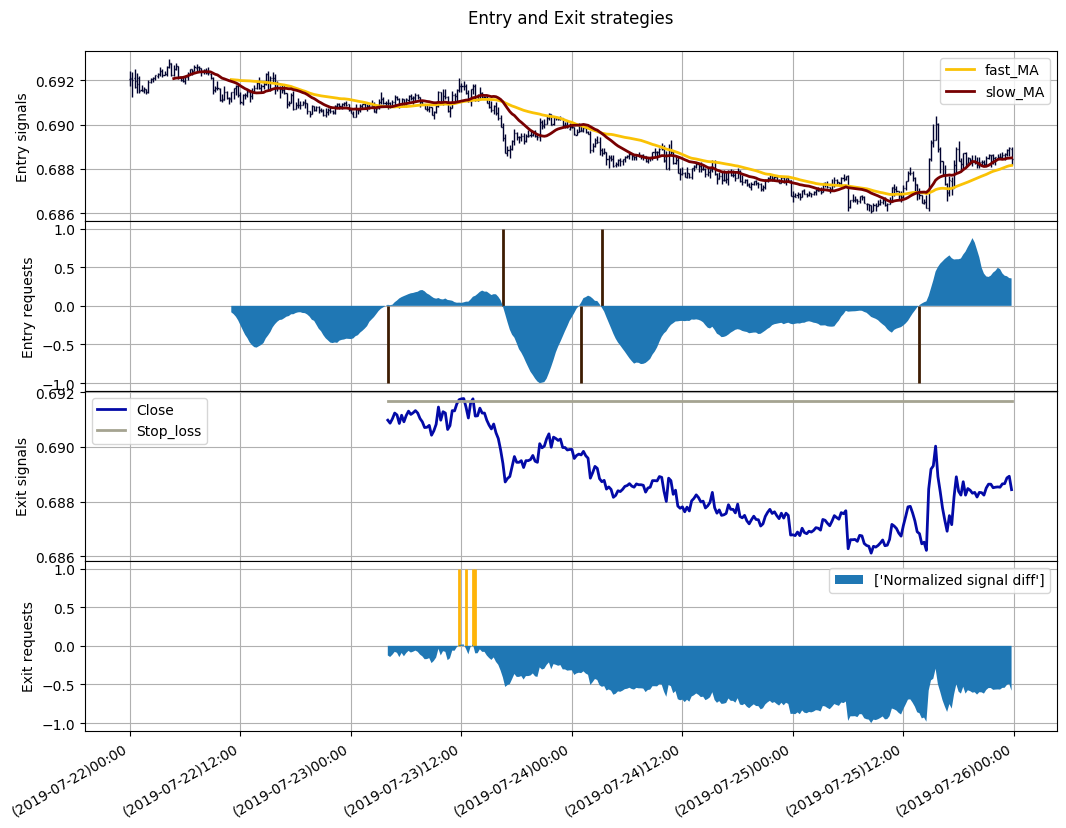

In [18]:
image_name = "entry_and_exit.png"; img_path = folder_images + image_name
gl.init_figure()
n_rows, n_cols = 4,1; size_inches = [12, 8]
ax1 = gl.subplot2grid((n_rows, n_cols),(0,0))
ax2 = gl.subplot2grid((n_rows, n_cols),(1,0), sharex = ax1)
ax3 = gl.subplot2grid((n_rows, n_cols),(2,0), sharex = ax1)
ax4 = gl.subplot2grid((n_rows, n_cols),(3,0), sharex = ax1)

portfolio[symbol_name][timeframe].plot_barchart(axes = ax1, labels = ["Entry and Exit strategies", "", "Entry signals"])
gl.plot(entry_strategy_series.index, entry_strategy_series, legend = list(entry_strategy_series.columns), axes =ax1)

difference = entry_strategy_series["slow_MA"] - entry_strategy_series["fast_MA"]
normalized_difference = difference/np.max(np.abs((difference)))
gl.fill_between(entry_strategy_series.index, normalized_difference, 
                labels = ["", "", "Entry requests"], legend = "Normalized signal diff", axes =ax2)
gl.stem(entry_strategy_series.index,entry_series, axes = ax2, legend = "Trades")

## Plot exit
gl.plot(exit_strategy_series.index, exit_strategy_series, axes = ax3, 
        legend = list(exit_strategy_series.columns), labels = ["", "", "Exit signals"])

difference = exit_strategy_series["Close"] - exit_strategy_series["Stop_loss"]
normalized_difference = difference/np.max(np.abs((difference)))
gl.fill_between(exit_strategy_series.index, normalized_difference, legend = ["Normalized signal diff"], axes =ax4)
gl.stem(exit_series.index,exit_series, axes = ax4, legend = "Exits", labels = ["", "", "Exit requests"])

gl.subplots_adjust(left=.09, bottom=.10, right=.90, top=.95, wspace=.20, hspace=0, hide_xaxis = True)

gl.save_figure(img_path, dpi = 100, size_inches = size_inches, close = True)
Image(img_path)